# **Preparación entorno**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive//TFM/

/content/drive/MyDrive/TFM


In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.0 MB/s eta 0:00:00


In [ ]:
# Cargamos liberías necesarias
import pandas as pd
import numpy as np
import pydicom
import cv2
import pywt
import matplotlib.pyplot as plt
import os
import random
import uuid
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split

In [ ]:
calc_df = pd.read_csv('data/calc_df.csv')
calc_df.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...,/content/drive/MyDrive/TFM/data/CBIS-DDSM/Calc...


# **Técnicas de mejora imagen**

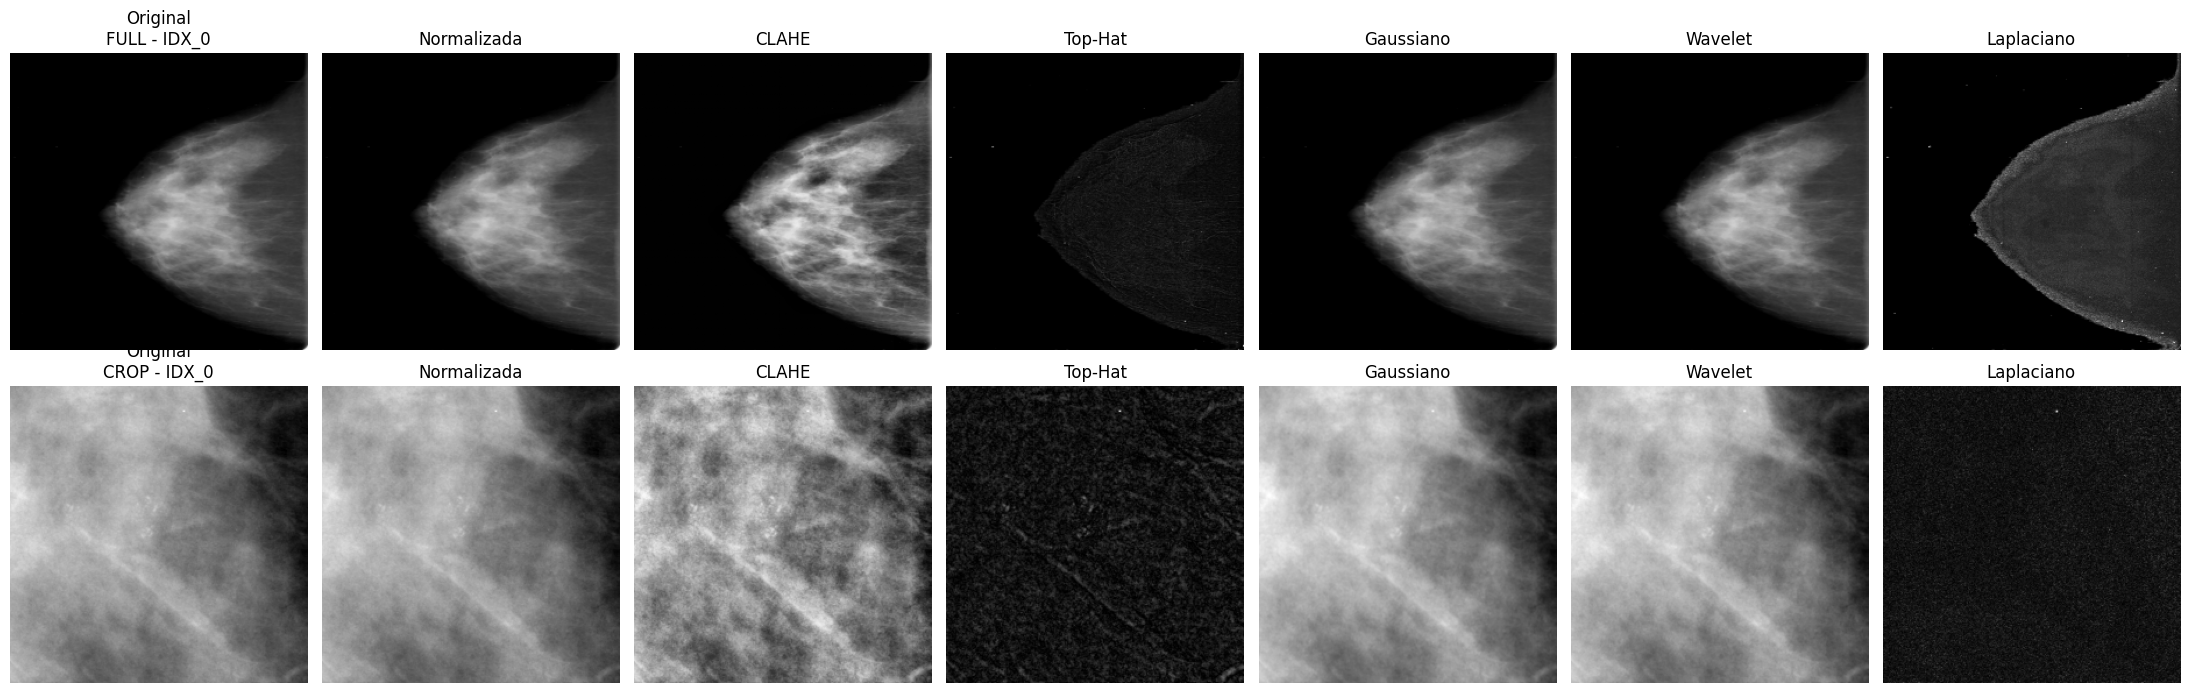

In [ ]:
# Función para leer imagen DICOM
def load_dicom_image(path):
    ds = pydicom.dcmread(path)
    image = ds.pixel_array.astype(np.float32)
    return image

# Redimensionamos la imagen
def resize_image(img, size=(256, 256)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

# Normalización
def normalize_image(img):
    img -= np.min(img)
    img /= np.max(img) + 1e-8
    return img

# CLAHE
def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    img_uint8 = np.uint8(img * 255)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img_uint8) / 255.0

# Top-Hat
def apply_tophat(img, kernel_size=(15, 15)):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    img_uint8 = np.uint8(img * 255)
    return cv2.morphologyEx(img_uint8, cv2.MORPH_TOPHAT, kernel) / 255.0

# Filtro Gaussiano
def apply_gaussian_filter(img, ksize=(5, 5), sigma=1):
    return cv2.GaussianBlur(img, ksize, sigma)

# Filtro Wavelet
def apply_wavelet_filter(img):
    coeffs2 = pywt.dwt2(img, 'db1')
    cA, _ = coeffs2
    img_rec = pywt.idwt2((cA, (None, None, None)), 'db1')
    return np.clip(img_rec, 0, 1)

# Laplaciano
def apply_laplacian(img):
    img_uint8 = np.uint8(img * 255)
    laplacian = cv2.Laplacian(img_uint8, cv2.CV_64F, ksize=3)
    return cv2.convertScaleAbs(laplacian) / 255.0

# Mostramos preprocesamiento para imagen completa y recortada
def show_preprocessing_steps(row, target_size=(256, 256)):
    """
    row: fila del DataFrame calc_df
    target_size: tamaño final para visualización
    """
    image_id = f'IDX_{row.name}'
    full_path = row['image file path']
    crop_path = row['cropped image file path']

    def preprocess_all(path):
        try:
            original = load_dicom_image(path)
        except Exception as e:
            print(f"Error al cargar {path}: {e}")
            return [np.zeros(target_size)] * 7

        norm = normalize_image(original)
        clahe = apply_clahe(norm)
        tophat = apply_tophat(norm)
        gaussian = apply_gaussian_filter(norm)
        wavelet = apply_wavelet_filter(norm)
        laplacian = apply_laplacian(norm)

        return [
            resize_image(original, target_size),
            resize_image(norm, target_size),
            resize_image(clahe, target_size),
            resize_image(tophat, target_size),
            resize_image(gaussian, target_size),
            resize_image(wavelet, target_size),
            resize_image(laplacian, target_size),
        ]

    # Procesamos ambas imágenes
    images_full = preprocess_all(full_path)
    images_crop = preprocess_all(crop_path)

    titles = [
        "Original",
        "Normalizada",
        "CLAHE",
        "Top-Hat",
        "Gaussiano",
        "Wavelet",
        "Laplaciano"
    ]

    # Visualizamos ambas series
    plt.figure(figsize=(22, 7))
    for i in range(7):
        plt.subplot(2, 7, i + 1)
        plt.imshow(images_full[i], cmap='gray')
        title = titles[i]
        if i == 0:
            title += f"\nFULL - {image_id}"
        plt.title(title)
        plt.axis('off')

        plt.subplot(2, 7, i + 8)
        plt.imshow(images_crop[i], cmap='gray')
        title = titles[i]
        if i == 0:
            title += f"\nCROP - {image_id}"
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Ejemplo con una fila de calc_df
show_preprocessing_steps(calc_df.iloc[0])

# **CLAHE**

In [ ]:
calc_df_clahe = calc_df.copy()

In [ ]:
# Ruta de destino para guardar imágenes preprocesadas (imagen completa)
output_dir_full = "/content/drive/MyDrive/TFM/data/clahe_full"
os.makedirs(output_dir_full, exist_ok=True)

# Lista para almacenar las rutas de las imágenes procesadas
clahe_full_paths = []

for idx, row in tqdm(calc_df_clahe.iterrows(), total=len(calc_df_clahe), desc="Procesando imágenes completas con CLAHE"):

    full_path = row["image file path"]

    try:
        # 1. Cargamos imagen DICOM
        ds = pydicom.dcmread(full_path)
        image = ds.pixel_array.astype(np.float32)

        # 2. Normalizar a rango 0–255 para CLAHE
        image -= np.min(image)
        image /= (np.max(image) + 1e-8)
        image_uint8 = np.uint8(image * 255)

        # 3. Aplicamos CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_img = clahe.apply(image_uint8)

        # 4. Redimensionamos después de CLAHE
        resized_img = cv2.resize(clahe_img, (224, 224), interpolation=cv2.INTER_AREA)

        # 5. Convertimos a 3 canales (RGB)
        rgb_img = np.stack([resized_img] * 3, axis=-1)

        # 6. Normalizamos a [0, 1]
        rgb_img = rgb_img.astype(np.float32) / 255.0

        # 7. Guardamos como .jpg
        save_img = np.uint8(rgb_img * 255)
        save_path = os.path.join(output_dir_full, f"clahe_full_{idx}.jpg")
        cv2.imwrite(save_path, save_img)

        # 8. Guardamos ruta
        clahe_full_paths.append(save_path)

    except Exception as e:
        print(f"Error en {full_path}: {e}")
        clahe_full_paths.append(None)

# Añadimos columna con rutas a calc_df_clahe
calc_df_clahe["clahe full path"] = clahe_full_paths

Procesando imágenes completas con CLAHE: 100%|██████████| 1872/1872 [45:45<00:00,  1.47s/it]


In [ ]:
# Guardamos el nuevo DataFrame
calc_df_clahe.to_csv("/content/drive/MyDrive/TFM/data/calc_df_clahe.csv", index=False)

# **Balanceo de clases**

In [ ]:
calc_df = pd.read_csv('data/calc_df_clahe.csv')

In [ ]:
# Codificamos las variable pathology
çmap = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}
calc_df['labels'] = calc_df['pathology'].replace(map).infer_objects(copy=False)

/tmp/ipython-input-30-1604457458.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  calc_df['labels'] = calc_df['pathology'].replace(map).infer_objects(copy=False)


## División dataset

In [ ]:
# Filtramos rutas válidas (no nulas) de imágenes procesadas con CLAHE
full_images = np.array(calc_df[calc_df["clahe full path"].notna() & calc_df["patient_id"].notna()]["clahe full path"].tolist())

# Obtenemos las etiquetas correspondientes a esas imágenes
full_labels = np.array(calc_df[calc_df["clahe full path"].notna() & calc_df["patient_id"].notna()]["labels"].tolist())

len(full_images)

1872

In [ ]:
# Concatenamos y dividimos el dataset
full_df = pd.DataFrame({'filepath': full_images, 'label': full_labels})
train_df, temp_df = train_test_split(full_df, test_size=0.2, stratify=full_df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [ ]:
# Guardamos en Drive los DataFrame
os.makedirs('/content/drive/MyDrive/TFM/splits', exist_ok=True)

train_df.to_csv('/content/drive/MyDrive/TFM/splits/train_split_bien.csv', index=False)
valid_df.to_csv('/content/drive/MyDrive/TFM/splits/valid_split_bien.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/TFM/splits/test_split_bien.csv', index=False)

## Balanceado eliminando imágenes de clase mayoritaria

In [ ]:
def subset_balanced(df, target_label=1, max_images=600):
    # Filtramos por la clase deseada
    df_class = df[df['label'] == target_label]

    # Agrupamos por paciente para mantener coherencia dentro de cada grupo
    grouped = df_class.groupby('patient_id')

    # Inicializamos lista para guardar los grupos seleccionados
    selected_rows = []
    total_images = 0

    # Recorremos pacientes
    for patient_id, group in grouped:
        group_size = group.shape[0]

        # Si añadir este grupo excede el máximo de imágenes, detener el proceso
        if total_images + group_size > max_images:
            break
        # Añadimos grupo completo del paciente a la lista
        selected_rows.append(group)
        total_images += group_size

    # Combinamos todos los grupos seleccionados en un solo DataFrame
    return pd.concat(selected_rows).reset_index(drop=True)

# Combinamos patient_id de calc_df en train_df, valid_df, and test_df
train_df = train_df.merge(calc_df[['clahe full path', 'patient_id']], left_on='filepath', right_on='clahe full path', how='left')
valid_df = valid_df.merge(calc_df[['clahe full path', 'patient_id']], left_on='filepath', right_on='clahe full path', how='left')
test_df = test_df.merge(calc_df[['clahe full path', 'patient_id']], left_on='filepath', right_on='clahe full path', how='left')

# Llamamos a la función para obtener hasta 600 imágenes de cada clase
df_1 = subset_balanced(train_df, target_label=1, max_images=600)
df_0 = subset_balanced(train_df, target_label=0, max_images=600)

# Concatenamos ambas clases y mezclamos aleatoriamente
train_df_600 = pd.concat([df_1, df_0]).sample(frac=1, random_state=42).reset_index(drop=True)

Número total de casos:
 label
0    600
1    538
Name: count, dtype: int64


<Axes: title={'center': 'Count of Tumour vs No Tumour'}, xlabel='label'>

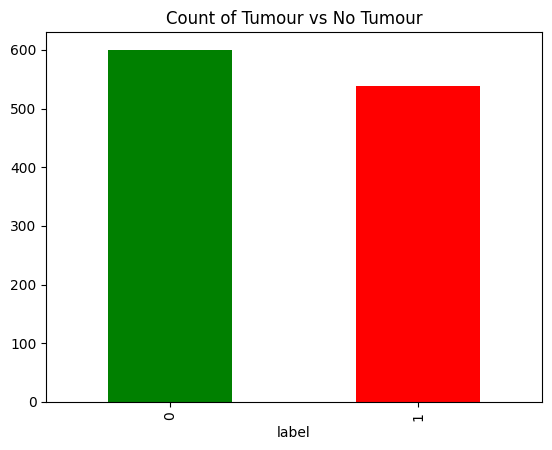

In [ ]:
print('Número total de casos:\n', train_df_600['label'].value_counts())
train_df_600['label'].value_counts().plot(kind='bar',color=['g','r'],
                title='Count of Tumour vs No Tumour')

In [ ]:
# Guardamos en CSV
output_path = "/content/drive/MyDrive/TFM/data/train_df_600.csv"
calc_df_balanced.to_csv(output_path, index=False)

print(f"Archivo guardado en: {output_path}")

Archivo guardado en: /content/drive/MyDrive/TFM/data/train_df_600.csv


## Data augmentation

In [ ]:
def augment_image(image):
    # Aplicamos volteo horizontal aleatorio (simula variación en la orientación)
    image = tf.image.random_flip_left_right(image)

    # image = tf.image.random_flip_up_down(image) No activamos flip vertical porque no es común en imágenes médicas

    # Ajuste aleatorio del brillo (simula variaciones de iluminación)
    image = tf.image.random_brightness(image, max_delta=0.3)

    # Ajuste aleatorio del contraste (simula diferentes niveles de exposición)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Ajuste aleatorio de la saturación
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    return image

In [ ]:
# Función para redimensionar a (224, 224, 3)
def resize_image(image_tensor):
    return tf.image.resize(image_tensor, [224, 224])

In [ ]:
# Función para aumentar y guardar imágenes para balancear el conjunto de datos
def augment_and_save_images(images_list, destination_dir, num_augments):
    """
    Aumenta y guarda imágenes en la carpeta destino para balancear el conjunto de datos.
    """
    for i in range(num_augments):
        # Seleccionamos aleatoriamente una imagen de la lista
        img_name = random.choice(images_list)
        abs_path = os.path.join(destination_dir, img_name)

        try:
            with Image.open(abs_path) as img:
                img = img.convert('RGB')

                # Convertimos imagen a tensor
                img_tensor = tf.convert_to_tensor(img)

                # Aplicamos aumentos
                augmented_image_tensor = augment_image(img_tensor)

                # Convertimos tensor a imagen PIL
                augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)

                # Quitamos extensión del nombre original (por ejemplo: "img_01.jpg" → "img_01")
                img_name_without_ext = os.path.splitext(img_name)[0]

                # Guardamos imagen aumentada con un nombre único
                augmented_image.save(
                    os.path.join(destination_dir, img_name_without_ext + f'_aug{i}.jpg'),
                    'JPEG'
                )

        except Exception:
            pass  # Se ignoran errores puntuales al procesar imágenes

In [ ]:
def copy_images(images, labels, source, destination, target_count=None):
    """
    Copia imágenes desde una carpeta origen a una carpeta destino en subcarpetas '0' y '1',
    asegurando nombres de archivo únicos, aplicando aumentos de datos y balanceando las clases.
    """

    benign_images = 0
    malignant_images = 0
    skipped_images = []

    # Creamos las subcarpetas de destino para cada clase
    category_dest_dir_zero = os.path.join(destination, '0')
    os.makedirs(category_dest_dir_zero, exist_ok=True)

    category_dest_dir_one = os.path.join(destination, '1')
    os.makedirs(category_dest_dir_one, exist_ok=True)

    # Listas para registrar imágenes ya copiadas de cada clase
    benign_images_list = []
    malignant_images_list = []

    # Recorremos imágenes y etiquetas
    for i, (image, label) in enumerate(zip(images, labels)):
        if os.path.exists(image):
            try:
                # Creamos un nombre único usando UUID
                filename = os.path.basename(image)
                unique_filename = f"{uuid.uuid4().hex}_{filename}"

                # Abrimos imagen, convertir a RGB y aplicar aumentos
                with Image.open(image) as img:
                    img = img.convert('RGB')
                    img_tensor = tf.convert_to_tensor(img)

                    # Redimensionamos y aumentamos la imagen
                    resized_img_tensor = resize_image(img_tensor)
                    augmented_image_tensor = augment_image(resized_img_tensor)

                    # Convertimos de nuevo a imagen PIL para guardarla
                    augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)

                    # Guardamos en la carpeta correspondiente
                    if label == 0:
                        benign_images_list.append(unique_filename)
                        dest_path = os.path.join(category_dest_dir_zero, unique_filename)
                        augmented_image.save(dest_path, 'JPEG')
                        benign_images += 1

                    elif label == 1:
                        malignant_images_list.append(unique_filename)
                        dest_path = os.path.join(category_dest_dir_one, unique_filename)
                        augmented_image.save(dest_path, 'JPEG')
                        malignant_images += 1

            except Exception as e:
                skipped_images.append(image)
        else:
            skipped_images.append(image)

    # Conteo actual de imágenes por clase
    benign_count = len(benign_images_list)
    malignant_count = len(malignant_images_list)

    # Si no se especifica un número objetivo, se iguala al tamaño de la clase mayor
    if target_count is None:
        target_count = max(benign_count, malignant_count)

    print(f"\n Objetivo de imágenes por clase: {target_count}")
    print(f" Benignas copiadas inicialmente: {benign_count}")
    print(f" Malignas copiadas inicialmente: {malignant_count}")

    # Determinamos cuántas imágenes adicionales se necesitan para cada clase
    additional_benign_needed = max(0, target_count - benign_count)
    additional_malignant_needed = max(0, target_count - malignant_count)

    # Aumentamos imágenes de la clase benigna si es necesario
    if additional_benign_needed > 0:
        print(f"Aumentando {additional_benign_needed} imágenes benignas...")
        augment_and_save_images(benign_images_list, category_dest_dir_zero, additional_benign_needed)

    # Aumentamos imágenes de la clase maligna si es necesario
    if additional_malignant_needed > 0:
        print(f"Aumentando {additional_malignant_needed} imágenes malignas...")
        augment_and_save_images(malignant_images_list, category_dest_dir_one, additional_malignant_needed)

    # Resumen final
    print(f"\n Copiado y balanceo completado.")
    print(f"Imágenes benignas finales (etiqueta 0): {target_count}")
    print(f"Imágenes malignas finales (etiqueta 1): {target_count}")
    print(f"Imágenes omitidas: {len(skipped_images)}")

    # Mostramos imágenes omitidas si las hubo
    if skipped_images:
        print("\nLista de imágenes omitidas:")
        for img in skipped_images:
            print(f"- {img}")

In [ ]:
# Ruta de origen donde se encuentran las imágenes CLAHE originales
source_dir = "/content/drive/MyDrive/TFM/data/clahe_full"

# Ruta de destino donde se guardarán las imágenes balanceadas y aumentadas
destination_dir_1000 = "/content/drive/MyDrive/TFM/data/augmented_train_1000"
destination_dir_2000 = "/content/drive/MyDrive/TFM/data/augmented_train_2000"
destination_dir_3000 = "/content/drive/MyDrive/TFM/data/augmented_train_3000"

# Ejecutamos la función para copiar, aumentar y balancear las imágenes en la carpeta destino
copy_images(train_df['filepath'].values, train_df['label'].values, source_dir, destination_dir_1000, target_count=1000)
copy_images(train_df['filepath'].values, train_df['label'].values, source_dir, destination_dir_2000, target_count=2000)
copy_images(train_df['filepath'].values, train_df['label'].values, source_dir, destination_dir_3000, target_count=3000)


 Objetivo de imágenes por clase: 1000
 Benignas copiadas inicialmente: 959
 Malignas copiadas inicialmente: 538
Aumentando 41 imágenes benignas...
Aumentando 462 imágenes malignas...

 Copiado y balanceo completado.
Imágenes benignas finales (etiqueta 0): 1000
Imágenes malignas finales (etiqueta 1): 1000
Imágenes omitidas: 0

 Objetivo de imágenes por clase: 2000
 Benignas copiadas inicialmente: 959
 Malignas copiadas inicialmente: 538
Aumentando 1041 imágenes benignas...
Aumentando 1462 imágenes malignas...

 Copiado y balanceo completado.
Imágenes benignas finales (etiqueta 0): 2000
Imágenes malignas finales (etiqueta 1): 2000
Imágenes omitidas: 0

 Objetivo de imágenes por clase: 3000
 Benignas copiadas inicialmente: 959
 Malignas copiadas inicialmente: 538
Aumentando 2041 imágenes benignas...
Aumentando 2462 imágenes malignas...

 Copiado y balanceo completado.
Imágenes benignas finales (etiqueta 0): 3000
Imágenes malignas finales (etiqueta 1): 3000
Imágenes omitidas: 0
